In [1]:
from machinelearning.mlpipeline import MLPipelines
from machinelearning.featexpl import FeaturesExplanation
from machinelearning.explorexplain import ExploreExplain

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


from sklearn.svm import SVC
from xgboost import XGBClassifier
import optuna
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier

from sklearn.gaussian_process import GaussianProcessClassifier
from catboost import CatBoostClassifier

csv_dir = 'data/EPIC_norm_pos.txt'
# csv_dir = 'data/composite_dataset.csv'
label = 'group'

# model = LogisticRegression()

%load_ext autoreload
%autoreload 2
%matplotlib inline

# %matplotlib inline


In [2]:
# dataloader
mlpipe = MLPipelines(label=label, csv_dir=csv_dir)
# mlpipe = MLPipelines(label=label, csv_dir=csv_dir, estimator=CatBoostClassifier())

# mlpipe._encode_labels()
mlpipe.normalize()
mlpipe.feature_selection(method='mrmr', num_features=50, inner_method='chi2')

# mlpipe.X=mlpipe.X.fillna(0)

Label mapping: {0: 'Factor1:CASE', 1: 'Factor1:CONTROL'}
There is no selected classifier.
Converting the raw data with minmax normalization method....
Normalization completed.


Normalization completed.
Number of significant features: 162 of 509 provided.


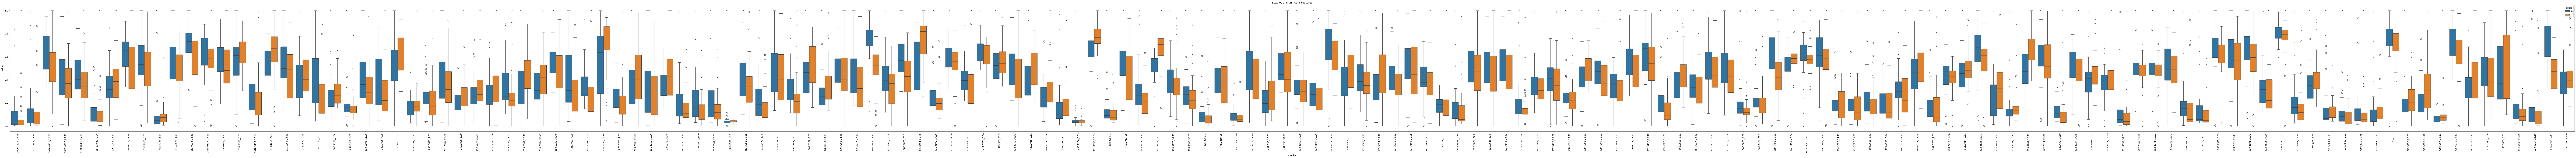

In [3]:
ee=ExploreExplain(X=mlpipe.X,y=mlpipe.y,normalization_method='minmax')
features = ee.statistical_difference(normalize=True)

In [4]:
mlpipe.X = mlpipe.X[features]
mlpipe.X.shape

(78, 162)

### Split the model Selection

<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


Outer fold of 1 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 5 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 2 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 4 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 3 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 5 round: 33% |████▎        | Elapsed Time: 0:00:42 ETA:   0:01:25
Outer fold of 1 round: 33% |████▎        | Elapsed Time: 0:00:43 ETA:   0:01:27
Outer fold of 4 round: 33% |████▎        | Elapsed Time: 0:00:43 ETA:   0:01:26
Outer fold of 3 round: 33% |████▎        | Elapsed Time: 0:00:42 ETA:   0:01:25
Outer fold of 2 round: 33% |████▎        | Elapsed Time: 0:00:52 ETA:   0:01:44
Outer fold of 1 round: 66% |████████▋    | Elapsed Time: 0:01:27 ETA:   0:00:43
Outer fold of 5 round: 66% |████████▋    | Elapsed Time: 0:01:28 ETA:   0:00:44
Outer fold of 1 round:100% |████████████

Finished with 1 round after 0.04 hours.


Outer fold of 5 round:100% |█████████████| Elapsed Time: 0:01:29 Time:  0:01:29


Finished with 5 round after 0.04 hours.


Outer fold of 4 round: 66% |████████▋    | Elapsed Time: 0:01:30 ETA:   0:00:45
Outer fold of 3 round: 66% |████████▋    | Elapsed Time: 0:01:26 ETA:   0:00:43
Outer fold of 4 round:100% |█████████████| Elapsed Time: 0:01:31 Time:  0:01:31


Finished with 4 round after 0.04 hours.
Finished with 3 round after 0.04 hours.


Outer fold of 3 round:100% |█████████████| Elapsed Time: 0:01:27 Time:  0:01:27
Outer fold of 2 round: 66% |████████▋    | Elapsed Time: 0:01:36 ETA:   0:00:48
Outer fold of 2 round:100% |█████████████| Elapsed Time: 0:01:37 Time:  0:01:37


Finished with 2 round after 0.04 hours.
Finished with 8 estimators


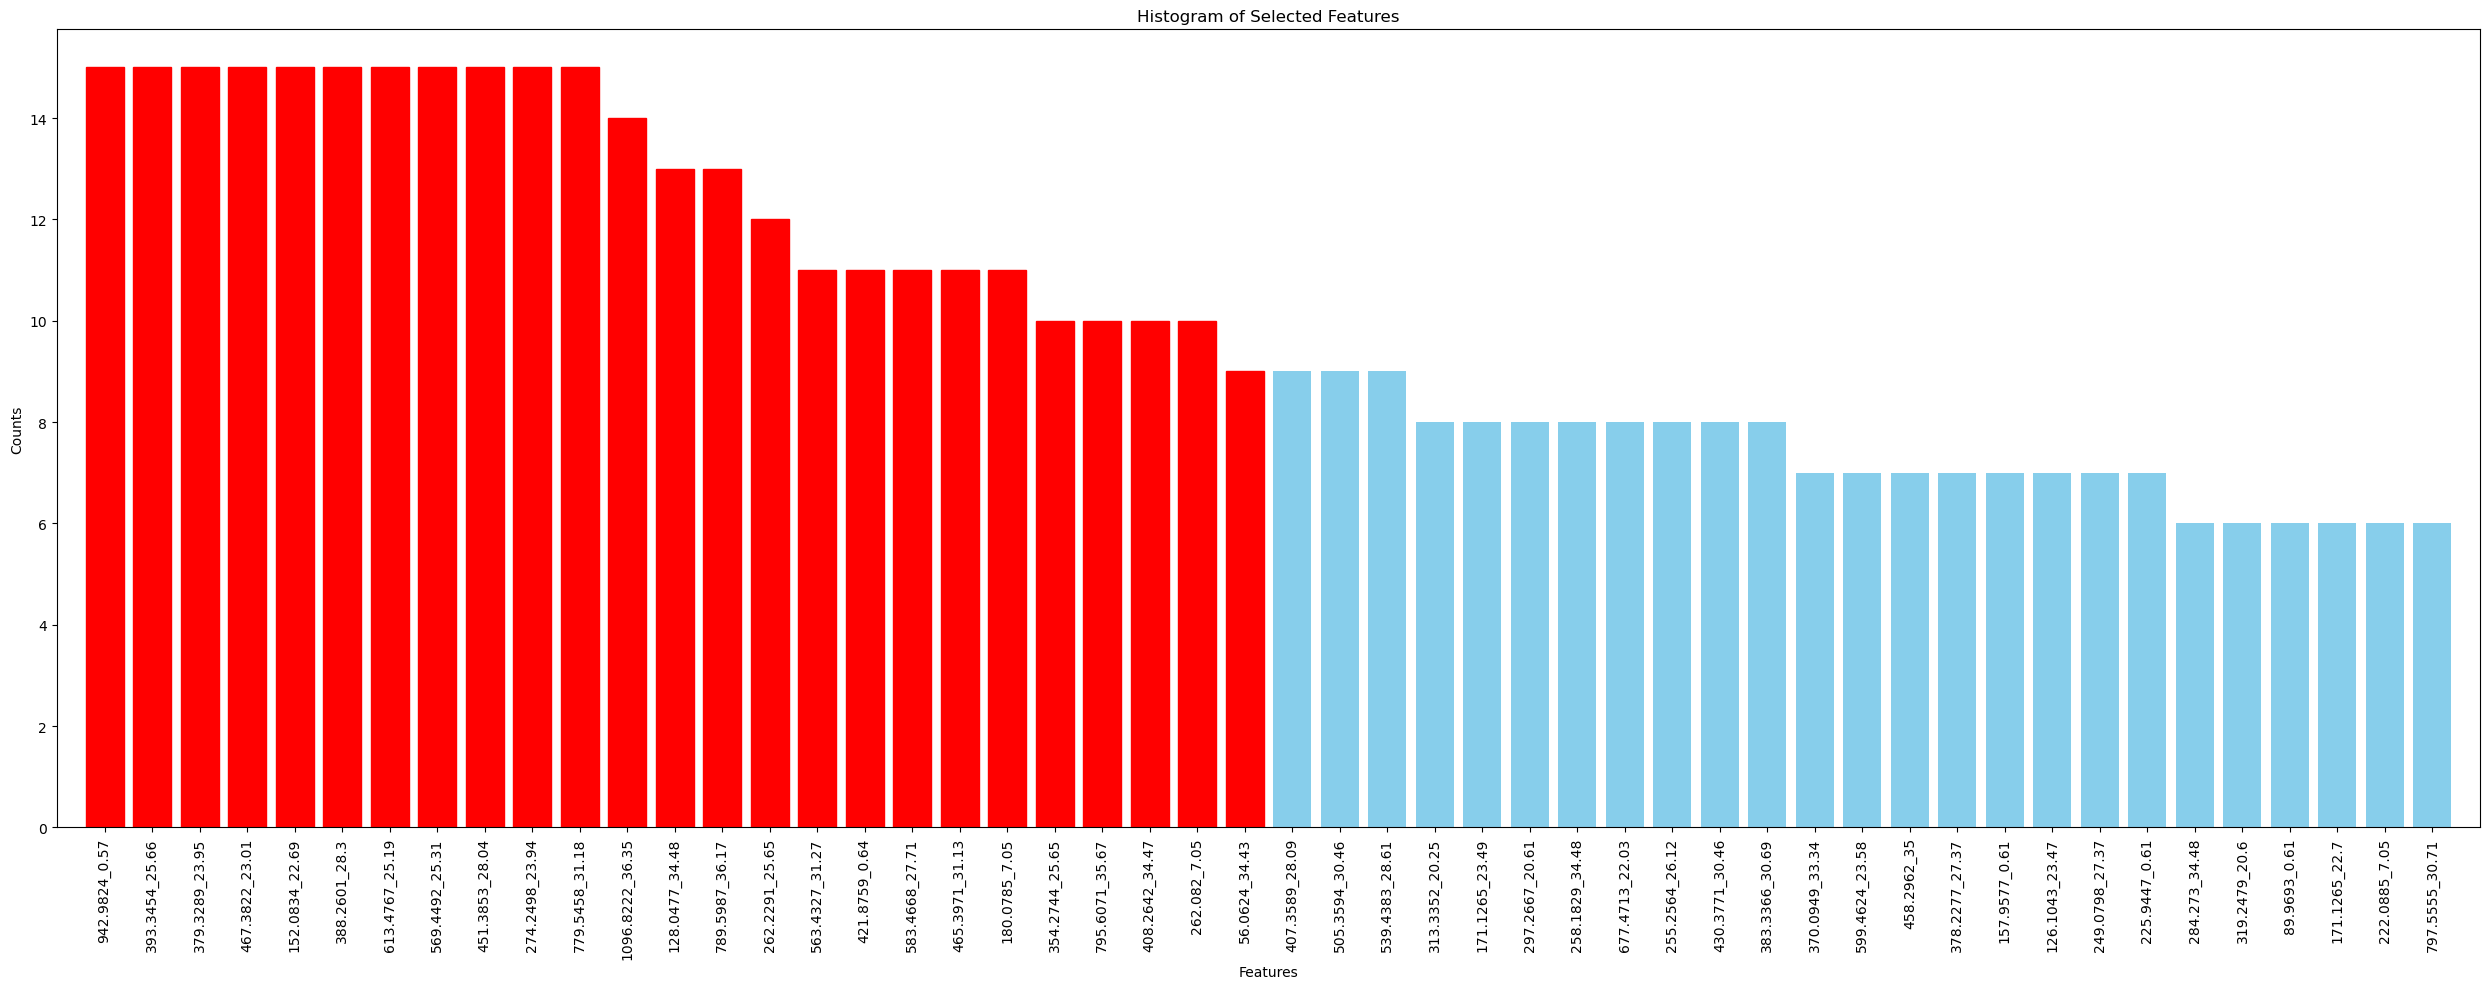

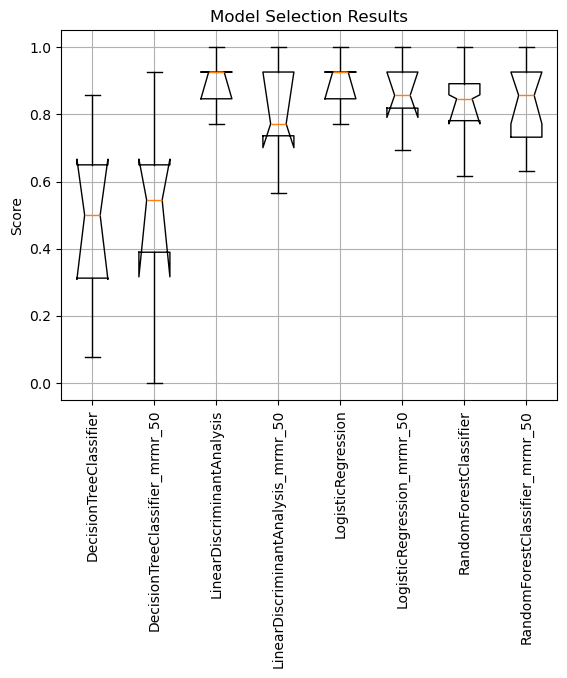

In [32]:
temp, listoffeat, all_feat = mlpipe.nested_cv(n_trials_ncv=50,rounds=5,plot='box',feature_selection_type='mrmr',most_imp_feat=25,outer_splits=3,inner_splits=3,hist_fit=True,N=50,num_features=[50,mlpipe.X.shape[1]],parallel='freely_parallel',return_all_N_features=True,search_on=[LinearDiscriminantAnalysis(), LogisticRegression(), RandomForestClassifier(), DecisionTreeClassifier()])

In [6]:
# features = all_feat[:24]
# mlpipe.X = mlpipe.X[features]

  0%|          | 0/2 [00:00<?, ?it/s]

Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty..
The None Score and the Hyperparameters of it will not be saved.


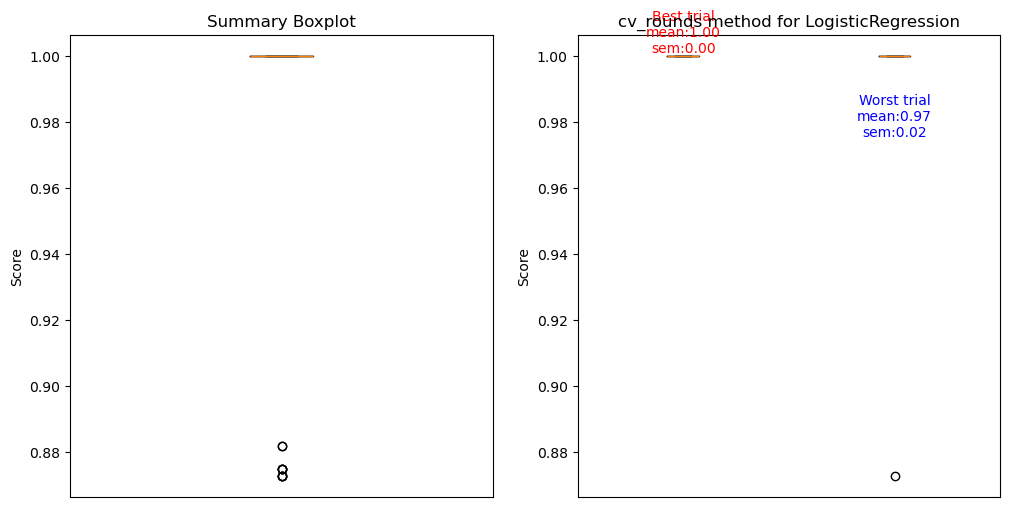

In [30]:
# mod,df=mlpipe.bayesian_search(estimator_name='RandomForestClassifier',n_trials=2,evaluation='cv_simple',calculate_shap=False)

param_grid = lambda trial: RandomForestClassifier(
            n_estimators=trial.suggest_int("n_estimators", 2, 200),
            criterion=trial.suggest_categorical("criterion", ["gini", "entropy"]),
            max_depth=trial.suggest_int("max_depth", 1, 50),
            min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 10),
            min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
            bootstrap=trial.suggest_categorical("bootstrap", [True, False]),
            n_jobs=-1,
        )

# param_grid = lambda trial: LogisticRegression(
#             penalty=trial.suggest_categorical("penalty", ["l1", "l2", None]),
#             C=trial.suggest_float("C", 0.1, 10.0),
#             solver = trial.suggest_categorical("solver",["newton-cg", "lbfgs", "sag", "saga", "liblinear"]),
#             fit_intercept=trial.suggest_categorical("fit_intercept", [True, False]),
#             n_jobs=-1,
#         )


mod,df=mlpipe.bayesian_search(estimator_name='LogisticRegression',n_trials=2,evaluation='cv_rounds',rounds=8)

Training with LogisticRegression:
Estimator: RandomForestClassifier
Best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': True}
Best matthews_corrcoef: 0.9549193338482966


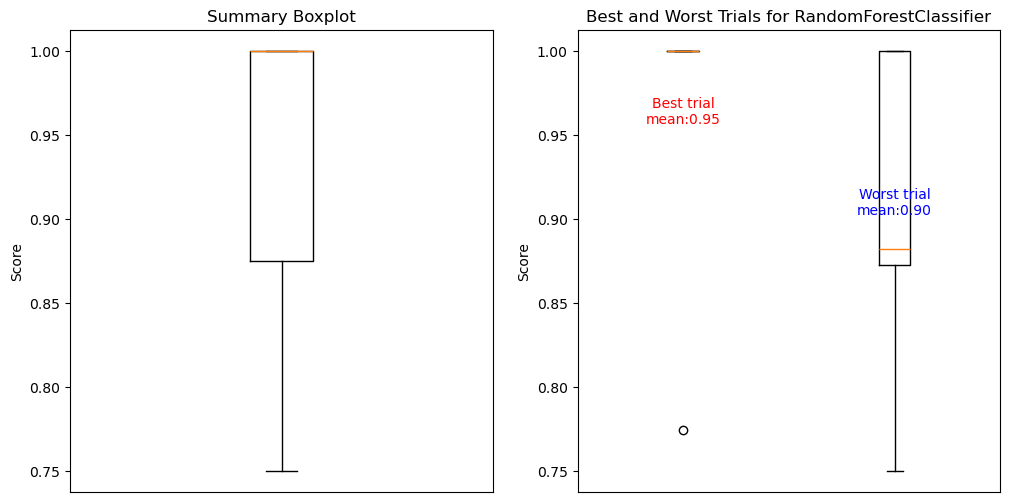

In [37]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# param_grid = {
#     'penalty': ['l1', 'l2', 'elasticnet', 'none'],
#     'C': [0.01, 0.1, 1, 10, 100],
#     'solver': ['lbfgs', 'liblinear', 'saga'],
#     'max_iter': [100, 200, 300, 400, 500]
# }

print('Training with LogisticRegression:')
model, df,  x_shap= mlpipe.random_search(estimator_name='RandomForestClassifier', parameter_grid=param_grid, calculate_shap=True)

In [33]:
df

mean_test_score  std_test_score  rank_test_score  \
5         0.975000        0.050000                1   
6         0.975000        0.050000                1   
9         0.975000        0.050000                1   
2         0.974574        0.050851                4   
0         0.950958        0.060132                5   
7         0.926383        0.060161                6   
4         0.901348        0.121567                7   
3         0.885798        0.119197                8   
1         0.849195        0.098412                9   
8         0.729627        0.117511               10   

                                              params  split0_test_score  \
5  {'n_estimators': 200, 'min_samples_split': 5, ...           1.000000   
6  {'n_estimators': 100, 'min_samples_split': 10,...           1.000000   
9  {'n_estimators': 50, 'min_samples_split': 10, ...           1.000000   
2  {'n_estimators': 200, 'min_samples_split': 2, ...           1.000000   
0  {'n_estimators': 100, 'min_samples_split': 10,...           1.000000   
7  {'n_estimators': 50, 'min_samples_split': 5, '...           0.881917   
4  {'n_estimators': 50, 'min_samples_split': 10, ...           1.000000   
3  {'n_estimators': 10, 'min_samples_split': 2, '...           0.674200   
1  {'n_estimators': 10, 'min_samples_split': 10, ...           0.881917   
8  {'n_estimators': 10, 'min_samples_split': 10, ...           0.516398   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  
5           1.000000           1.000000           0.875000              1.000  
6           1.000000           1.000000           0.875000              1.000  
9           1.000000           1.000000           0.875000              1.000  
2           1.000000           1.000000           0.872872              1.000  
0           1.000000           0.881917           0.872872              1.000  
7           1.000000           1.000000           0.875000              0.875  
4           1.000000           0.774597           0.732143              1.000  
3           1.000000           0.881917           0.872872              1.000  
1           0.881917           0.750000           0.732143              1.000  
8           0.750000           0.774597           0.732143              0.875

In [68]:
len(df.scores_per_cv[0])
# df.valid_hyperparameters[0]

50

In [64]:
fesel = FeaturesExplanation(best_estimator=mlpipe.best_estimator, X=mlpipe.X, y=mlpipe.y, label_mapping=mlpipe.label_mapping,shap_values=mlpipe.shap_values)

In [20]:
ee=ExploreExplain(X=mlpipe.X,y=mlpipe.y,normalization_method='minmax')
# ee.statistical_difference()

Normalization completed.


In [23]:
ee.umap_plot(data=mlpipe.X,labels=mlpipe.y)

Normalization completed.


In [81]:
mlpipe.y.shape

(78,)

In [54]:
# fesel.calculate_shap_values()

The shap values do not exist for the label 1. The following is the summary plot for all the labels.


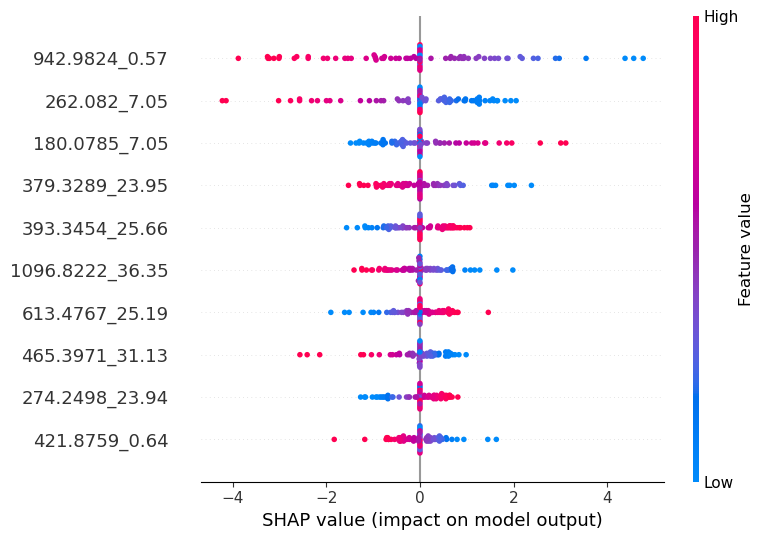

In [16]:
fesel.plot_shap_values()

In [77]:
np.array(temp['Scores'][0]).shape

(6,)

In [66]:
x = np.random.normal(loc= 0, size=1000)
# x = x.reshape(-1,1)
# x.shape

In [67]:
res = bootstrap((x,), np.median, confidence_level=0.5,random_state=42, n_resamples=1000)

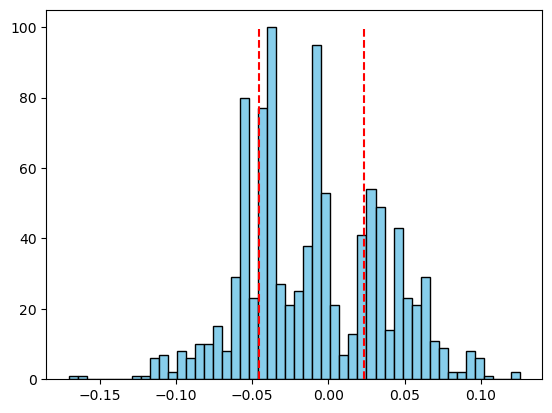

In [75]:
plt.hist(res.bootstrap_distribution, bins=50, color='skyblue', edgecolor='black')
plt.vlines(res.confidence_interval[0], 0, 100, color='red', linestyle='dashed')
plt.vlines(res.confidence_interval[1], 0, 100, color='red', linestyle='dashed')


In [17]:
# mod, dfs = mlpipe.bayesian_search(estimator_name='RandomForestClassifier',n_trials=10,evaluation='cv_rounds',rounds=10)

In [7]:
dfs.all_scores[0]

[1.0, 1.0, 0.8819171036881969, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [8]:
dfs

Hyperparameters     Score  \
0  {'n_estimators': 63, 'criterion': 'entropy', '...  1.000000   
1  {'n_estimators': 25, 'criterion': 'entropy', '...  1.000000   
2  {'n_estimators': 30, 'criterion': 'entropy', '...  1.000000   
3  {'n_estimators': 71, 'criterion': 'gini', 'max...  1.000000   
4  {'n_estimators': 16, 'criterion': 'gini', 'max...  0.881917   
5  {'n_estimators': 18, 'criterion': 'gini', 'max...  1.000000   
6  {'n_estimators': 56, 'criterion': 'gini', 'max...  0.881917   
7  {'n_estimators': 18, 'criterion': 'entropy', '...  1.000000   
8  {'n_estimators': 94, 'criterion': 'gini', 'max...  1.000000   
9  {'n_estimators': 155, 'criterion': 'gini', 'ma...  0.881917   

                Estimator       SEM  \
0  RandomForestClassifier  0.011202   
1  RandomForestClassifier  0.021384   
2  RandomForestClassifier  0.030336   
3  RandomForestClassifier  0.023011   
4  RandomForestClassifier  0.026097   
5  RandomForestClassifier  0.000000   
6  RandomForestClassifier  0.030934   
7  RandomForestClassifier  0.025079   
8  RandomForestClassifier  0.024174   
9  RandomForestClassifier  0.017833   

                                          all_scores  
0  [1.0, 1.0, 0.8819171036881969, 1.0, 1.0, 1.0, ...  
1  [1.0, 1.0, 1.0, 0.7745966692414834, 1.0, 1.0, ...  
2  [1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 0.7745966...  
3  [1.0, 1.0, 0.7745966692414834, 1.0, 1.0, 1.0, ...  
4  [0.7745966692414834, 0.7745966692414834, 0.629...  
5  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...  
6  [0.75, 0.629940788348712, 0.8819171036881969, ...  
7  [1.0, 1.0, 1.0, 1.0, 0.75, 0.8819171036881969,...  
8  [0.75, 0.8819171036881969, 1.0, 0.75, 0.75, 0....  
9  [0.75, 0.75, 0.75, 0.8819171036881969, 0.62994...

### Optuna test

In [72]:
from machinelearning.optuna_grid import optuna_grid

df = optuna.integration.OptunaSearchCV(
    estimator=LinearDiscriminantAnalysis(),
    param_distributions=optuna_grid['NestedCV_single']['LinearDiscriminantAnalysis'],
    scoring='matthews_corrcoef',
    cv=5,
    n_jobs=1,
    verbose=0,
    n_trials=10
)

df.fit(mlpipe.X, mlpipe.y)
dataframe = df.trials_dataframe()
trials = df.trials_


In [75]:
dataframe.head()

number     value             datetime_start          datetime_complete  \
0       0  0.975000 2024-04-21 19:47:16.255914 2024-04-21 19:47:16.275118   
1       1  0.746966 2024-04-21 19:47:16.275217 2024-04-21 19:47:16.293200   
2       2  1.000000 2024-04-21 19:47:16.293292 2024-04-21 19:47:16.309261   
3       3  1.000000 2024-04-21 19:47:16.309353 2024-04-21 19:47:16.324994   
4       4  0.925532 2024-04-21 19:47:16.325085 2024-04-21 19:47:16.340698   

                duration  params_shrinkage params_solver  \
0 0 days 00:00:00.019204          0.790562         eigen   
1 0 days 00:00:00.017983          0.004625         eigen   
2 0 days 00:00:00.015969          0.377538         eigen   
3 0 days 00:00:00.015641          0.390694          lsqr   
4 0 days 00:00:00.015613          0.095414          lsqr   

   params_store_covariance  params_tol  user_attrs_mean_fit_time  ...  \
0                    False     0.00100                  0.002247  ...   
1                    False     0.00010                  0.001968  ...   
2                     True     0.00100                  0.001754  ...   
3                    False     0.00100                  0.001682  ...   
4                    False     0.00001                  0.001684  ...   

   user_attrs_split0_test_score  user_attrs_split1_test_score  \
0                      1.000000                      1.000000   
1                      0.750000                      0.629941   
2                      1.000000                      1.000000   
3                      1.000000                      1.000000   
4                      0.881917                      1.000000   

   user_attrs_split2_test_score  user_attrs_split3_test_score  \
0                      1.000000                      0.875000   
1                      0.881917                      0.600099   
2                      1.000000                      1.000000   
3                      1.000000                      1.000000   
4                      1.000000                      0.872872   

   user_attrs_split4_test_score  user_attrs_std_fit_time  \
0                      1.000000                 0.000740   
1                      0.872872                 0.000112   
2                      1.000000                 0.000074   
3                      1.000000                 0.000091   
4                      0.872872                 0.000049   

   user_attrs_std_score_time  user_attrs_std_test_score  \
0                   0.000096                   0.050000   
1                   0.000158                   0.117761   
2                   0.000018                   0.000000   
3                   0.000017                   0.000000   
4                   0.000043                   0.060892   

                   system_attrs_terminator:cv_scores     state  
0                        [1.0, 1.0, 1.0, 0.875, 1.0]  COMPLETE  
1  [0.75, 0.629940788348712, 0.8819171036881969, ...  COMPLETE  
2                          [1.0, 1.0, 1.0, 1.0, 1.0]  COMPLETE  
3                          [1.0, 1.0, 1.0, 1.0, 1.0]  COMPLETE  
4  [0.8819171036881969, 1.0, 1.0, 0.8728715609439...  COMPLETE  

[5 rows x 22 columns]

In [58]:
# dataframe.
# trials[0].params
# print(dataframe.head())

# To extract just the parameters, filter columns by those starting with 'params_'
params_data = dataframe[[col for col in dataframe.columns if col.startswith('params_')]]

# Now, 'params_data' holds all the parameter values used across different trials
print(params_data.head())

AttributeError: 'function' object has no attribute 'columns'

### Running tests

##### Results Table

| Method | Features | Outer | Inner | Rounds | Trials | Feature_selection | Device |**Time X Hours**|Coments|
|--------|----------|-------|-------|--------|--------|-------------------|--------|--------|----------|
|Dynamic|200|3|3|5|50|mrmr|laptop|0.22|pool(process=num_cores)|
|Dynamic|200|3|3|5|50|mrmr|laptop|paketo|pool(process=num_cores), optuna_multi|
|Dynamic|200|3|3|5|50|mrmr|laptop|paketo|pool(process=num_cores,maxtasksperchild=1), optuna_multi|
|Dynamic|200|3|3|5|50|mrmr|laptop|0.21|pool(maxtasksperchild=1)|
|Dynamic|200|3|3|5|50|mrmr|laptop|paketo|for loop for rounds, optuna_multi|
|Dynamic|200|3|3|5|50|mrmr|laptop|paketo|for loop for rounds with specified threads for numpy and to outer, optuna_multi|
|Dynamic|200|3|3|5|50|mrmr|laptop|paketo|for loop for rounds with specified threads for numpy and freee outer, optuna_multi|
|Freely|200|3|3|5|50|mrmr|laptop|0.18|No|
|ThrPerRound|200|3|3|5|50|mrmr|laptop|0.34|No|
|Freely|509|5|5|10|100|mrmr|laptop|5.2 hours|No|
|ThrPerRound|509|5|5|10|100|mrmr|laptop|8 hours|4.5-8 hours|


##### **Dynamic Parallel** (1st way 5-8 hours)

Your Dataset contains NaN values. Some estimators does not work with NaN values.
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


Outer fold of 1 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 5 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 3 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 4 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 2 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 5 round: 33% |████▎        | Elapsed Time: 0:00:15 ETA:   0:00:31
Outer fold of 3 round: 33% |████▎        | Elapsed Time: 0:00:15 ETA:   0:00:31
Outer fold of 4 round: 33% |████▎        | Elapsed Time: 0:00:14 ETA:   0:00:28
Outer fold of 1 round: 33% |████▎        | Elapsed Time: 0:00:21 ETA:   0:00:43
Outer fold of 2 round: 33% |████▎        | Elapsed Time: 0:00:15 ETA:   0:00:31
Outer fold of 5 round: 66% |████████▋    | Elapsed Time: 0:00:30 ETA:   0:00:15
Outer fold of 4 round: 66% |████████▋    | Elapsed Time: 0:00:28 ETA:   0:00:14
Outer fold of 3 round: 66% |████████▋   

Finished with 5 round after 0.01 hours.


Outer fold of 4 round:100% |█████████████| Elapsed Time: 0:00:29 Time:  0:00:29


Finished with 4 round after 0.01 hours.


Outer fold of 3 round:100% |█████████████| Elapsed Time: 0:00:31 Time:  0:00:31


Finished with 3 round after 0.01 hours.


Outer fold of 2 round: 66% |████████▋    | Elapsed Time: 0:00:30 ETA:   0:00:15
Outer fold of 2 round:100% |█████████████| Elapsed Time: 0:00:31 Time:  0:00:31


Finished with 2 round after 0.02 hours.


Outer fold of 1 round: 66% |████████▋    | Elapsed Time: 0:00:46 ETA:   0:00:23
Outer fold of 1 round:100% |█████████████| Elapsed Time: 0:00:47 Time:  0:00:47


Finished with 1 round after 0.02 hours.
Finished with 12 estimators


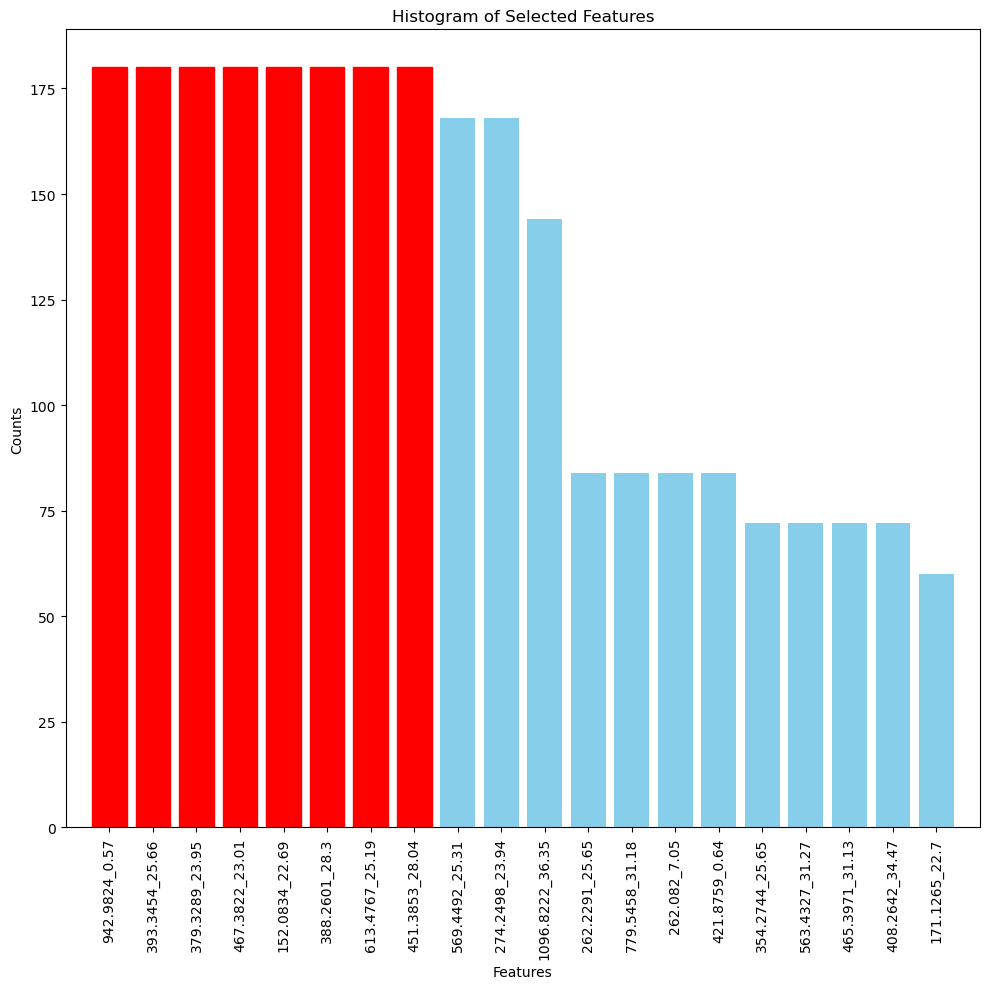

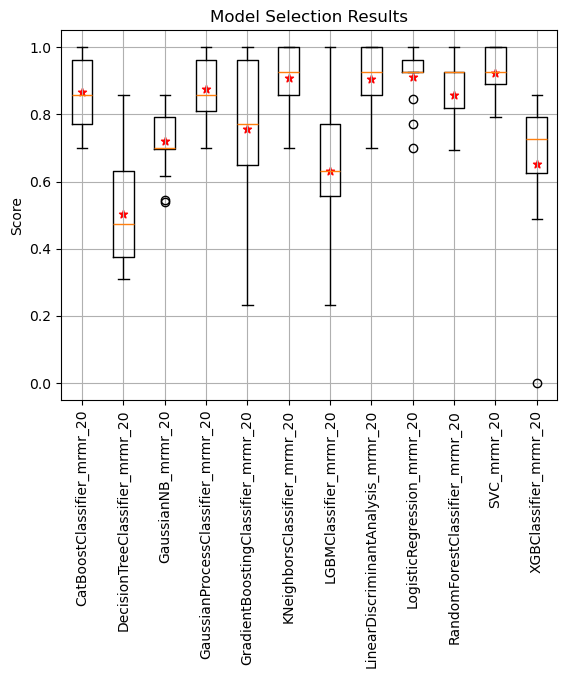

Normalization completed.


  0%|          | 0/100 [00:00<?, ?it/s]

For the SVC model: 
Best parameters: {'C': 10, 'kernel': 'linear', 'probability': True, 'shrinking': True, 'decision_function_shape': 'ovo'}
Best matthews_corrcoef: 1.0


In [5]:
# fitted_mod, df = mlpipe.model_selection(optimizer='bayesian_search',n_trials_ncv=100,n_trials=100,rounds=10,score='matthews_corrcoef', return_best_model=True,plot='box',return_scores_df=True,choose_model=False,feature_selection_type='mrmr',outer_splits=5,inner_splits=5,hist_fit=True,parallel='dynamic_parallel')
fitted_mod, df = mlpipe.model_selection(optimizer='bayesian_search',n_trials_ncv=10,n_trials=100,rounds=5,score='matthews_corrcoef', return_best_model=True,plot='box',return_scores_df=True,choose_model=False,feature_selection_type='mrmr',most_imp_feat=8,outer_splits=3,inner_splits=3,hist_fit=True,num_features=20,N=20,parallel='freely_parallel')

##### **Freely Parallel**  (4-5 hours)

<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


/home/spyros/miniconda3/envs/ai4meta/lib/python3.11/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
Outer fold of 8 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 5 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 10 round:  0% |            | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 9 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 3 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 2 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 6 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
/home/spyros/miniconda3/envs/ai4meta/lib/python3.11/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will

Finished with 8 round after 3.95 hours.


Outer fold of 1 round: 60% |███████▊     | Elapsed Time: 2:11:56 ETA:   1:27:57
Outer fold of 2 round: 60% |███████▊     | Elapsed Time: 3:01:49 ETA:   2:01:12
Outer fold of 3 round: 80% |██████████▍  | Elapsed Time: 3:14:11 ETA:   0:48:32
Outer fold of 3 round:100% |█████████████| Elapsed Time: 3:14:12 Time:  3:14:12


Finished with 3 round after 4.09 hours.


Outer fold of 10 round: 80% |█████████▌  | Elapsed Time: 3:23:23 ETA:   0:50:50
Outer fold of 10 round:100% |████████████| Elapsed Time: 3:23:24 Time:  3:23:24


Finished with 10 round after 4.10 hours.


Outer fold of 6 round: 60% |███████▊     | Elapsed Time: 3:04:07 ETA:   2:02:44
Outer fold of 5 round: 80% |██████████▍  | Elapsed Time: 3:30:14 ETA:   0:52:33
Outer fold of 5 round:100% |█████████████| Elapsed Time: 3:30:15 Time:  3:30:15


Finished with 5 round after 4.20 hours.


Outer fold of 2 round: 80% |██████████▍  | Elapsed Time: 3:28:23 ETA:   0:52:05
Outer fold of 2 round:100% |█████████████| Elapsed Time: 3:28:24 Time:  3:28:24


Finished with 2 round after 4.51 hours.


Outer fold of 4 round: 60% |███████▊     | Elapsed Time: 3:29:05 ETA:   2:19:23
Outer fold of 7 round: 80% |██████████▍  | Elapsed Time: 3:27:42 ETA:   0:51:55
Outer fold of 7 round:100% |█████████████| Elapsed Time: 3:27:43 Time:  3:27:43


Finished with 7 round after 4.71 hours.


Outer fold of 9 round: 80% |██████████▍  | Elapsed Time: 3:59:16 ETA:   0:59:49
Outer fold of 9 round:100% |█████████████| Elapsed Time: 3:59:17 Time:  3:59:17


Finished with 9 round after 4.77 hours.


Outer fold of 6 round: 80% |██████████▍  | Elapsed Time: 3:41:28 ETA:   0:55:22
Outer fold of 6 round:100% |█████████████| Elapsed Time: 3:41:29 Time:  3:41:29


Finished with 6 round after 4.81 hours.


Outer fold of 1 round: 80% |██████████▍  | Elapsed Time: 3:09:58 ETA:   0:47:29


Finished with 1 round after 5.01 hours.


Outer fold of 1 round:100% |█████████████| Elapsed Time: 3:09:59 Time:  3:09:59
Outer fold of 4 round: 80% |██████████▍  | Elapsed Time: 3:54:41 ETA:   0:58:40


Finished with 4 round after 5.10 hours.
Finished with 12 estimators
No features were selected.


Outer fold of 4 round:100% |█████████████| Elapsed Time: 3:54:42 Time:  3:54:42


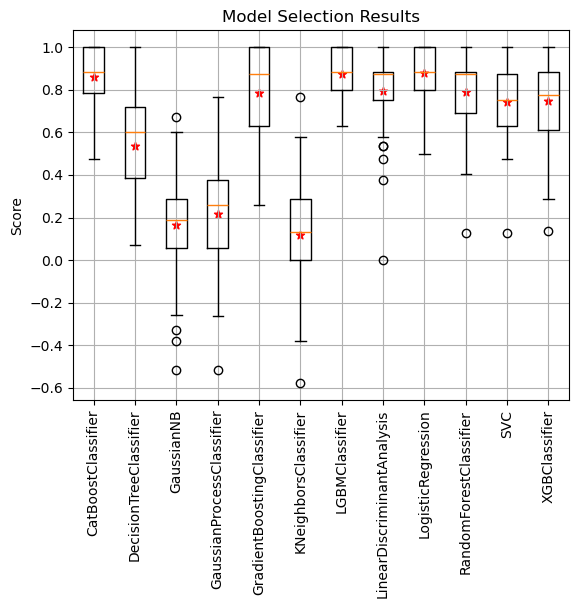

  0%|          | 0/100 [00:00<?, ?it/s]

/home/spyros/miniconda3/envs/ai4meta/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=9.22777e-22): result may not be accurate.
  warnings.warn(
/home/spyros/miniconda3/envs/ai4meta/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies

For the LogisticRegression model: 
Best parameters: {'penalty': 'l1', 'C': 3.950402117443433, 'solver_1': 'saga', 'max_iter': 731, 'fit_intercept': False}
Best matthews_corrcoef: 0.9509577329264332


In [4]:
fitted_mod, df = mlpipe.model_selection(optimizer='bayesian_search',n_trials_ncv=100,n_trials=100,rounds=10,score='matthews_corrcoef', return_best_model=True,plot='box',return_scores_df=True,choose_model=False,feature_selection_type='mrmr',outer_splits=5,inner_splits=5,hist_fit=True,parallel='freely_parallel')

##### **Thread per Round** (4.5-8 hours)

<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


Outer fold of 10 round:  0% |            | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 7 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 2 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 4 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 1 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 3 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 6 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 9 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 8 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 5 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 10 round: 20% |██▍         | Elapsed Time: 0:54:18 ETA:   3:37:13
Outer fold of 4 round: 20% |██▌          | Elapsed Time: 1:01:26 ETA:   4:05:47
Outer fold of 9 round: 20% |██▌         

Finished with 4 round after 4.57 hours.


Outer fold of 6 round: 60% |███████▊     | Elapsed Time: 3:34:29 ETA:   2:22:59
Outer fold of 7 round: 40% |█████▏       | Elapsed Time: 3:54:47 ETA:   5:52:10
Outer fold of 9 round: 60% |███████▊     | Elapsed Time: 4:01:11 ETA:   2:40:47
Outer fold of 3 round: 60% |███████▊     | Elapsed Time: 4:28:22 ETA:   2:58:55
Outer fold of 8 round: 40% |█████▏       | Elapsed Time: 4:18:17 ETA:   6:27:26
Outer fold of 6 round: 80% |██████████▍  | Elapsed Time: 4:50:18 ETA:   1:12:34
Outer fold of 6 round:100% |█████████████| Elapsed Time: 4:50:19 Time:  4:50:19


Finished with 6 round after 5.99 hours.


Outer fold of 2 round: 40% |█████▏       | Elapsed Time: 5:20:09 ETA:   8:00:14
Outer fold of 7 round: 60% |███████▊     | Elapsed Time: 5:22:39 ETA:   3:35:06
Outer fold of 9 round: 80% |██████████▍  | Elapsed Time: 5:09:39 ETA:   1:17:24
Outer fold of 9 round:100% |█████████████| Elapsed Time: 5:09:40 Time:  5:09:40


Finished with 9 round after 6.32 hours.


Outer fold of 8 round: 60% |███████▊     | Elapsed Time: 5:10:25 ETA:   3:26:56
Outer fold of 10 round: 60% |███████▏    | Elapsed Time: 5:50:25 ETA:   3:53:36
Outer fold of 3 round: 80% |██████████▍  | Elapsed Time: 5:36:56 ETA:   1:24:14
Outer fold of 3 round:100% |█████████████| Elapsed Time: 5:36:57 Time:  5:36:57


Finished with 3 round after 6.71 hours.


Outer fold of 5 round: 60% |███████▊     | Elapsed Time: 5:26:45 ETA:   3:37:50
Outer fold of 1 round: 80% |██████████▍  | Elapsed Time: 5:49:58 ETA:   1:27:29
Outer fold of 1 round:100% |█████████████| Elapsed Time: 5:49:59 Time:  5:49:59


Finished with 1 round after 6.90 hours.


Outer fold of 7 round: 80% |██████████▍  | Elapsed Time: 6:12:20 ETA:   1:33:05
Outer fold of 7 round:100% |█████████████| Elapsed Time: 6:12:21 Time:  6:12:21


Finished with 7 round after 7.10 hours.


Outer fold of 2 round: 60% |███████▊     | Elapsed Time: 6:14:45 ETA:   4:09:50
Outer fold of 8 round: 80% |██████████▍  | Elapsed Time: 6:00:53 ETA:   1:30:13
Outer fold of 8 round:100% |█████████████| Elapsed Time: 6:00:54 Time:  6:00:54


Finished with 8 round after 7.34 hours.


Outer fold of 10 round: 80% |█████████▌  | Elapsed Time: 6:37:20 ETA:   1:39:20
Outer fold of 10 round:100% |████████████| Elapsed Time: 6:37:21 Time:  6:37:21


Finished with 10 round after 7.36 hours.


Outer fold of 5 round: 80% |██████████▍  | Elapsed Time: 6:40:58 ETA:   1:40:14
Outer fold of 5 round:100% |█████████████| Elapsed Time: 6:40:59 Time:  6:40:59


Finished with 5 round after 8.07 hours.


Outer fold of 2 round: 80% |██████████▍  | Elapsed Time: 7:20:16 ETA:   1:50:04


Finished with 2 round after 8.23 hours.
Finished with 12 estimators
No features were selected.


Outer fold of 2 round:100% |█████████████| Elapsed Time: 7:20:17 Time:  7:20:17


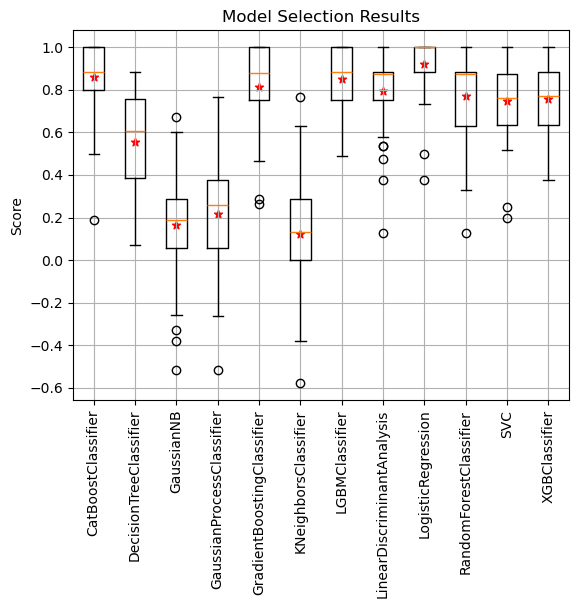

  0%|          | 0/100 [00:00<?, ?it/s]

/home/spyros/miniconda3/envs/ai4meta/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=5.29516e-22): result may not be accurate.
  warnings.warn(
/home/spyros/miniconda3/envs/ai4meta/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies

For the LogisticRegression model: 
Best parameters: {'penalty': 'l1', 'C': 8.302326622139802, 'solver_1': 'liblinear', 'max_iter': 609, 'fit_intercept': False}
Best matthews_corrcoef: 0.9273411536640725


In [7]:
fitted_mod, df = mlpipe.model_selection(optimizer='bayesian_search',n_trials_ncv=100,n_trials=100,rounds=10,score='matthews_corrcoef', return_best_model=True,plot='box',return_scores_df=True,choose_model=False,feature_selection_type='mrmr',outer_splits=5,inner_splits=5,hist_fit=True,parallel='thread_per_round')

### Final models tests

In [3]:
for estim_name, estimator in mlpipe.available_clfs.items():
    print(f'starting with {estim_name} estimator:')
    mlpipe.bayesian_search(estimator_name=estim_name,n_trials=20)
    

starting with RandomForestClassifier estimator:


  0%|          | 0/20 [00:00<?, ?it/s]

For the RandomForestClassifier model: 
Best parameters: {'n_estimators': 87, 'criterion': 'entropy', 'max_depth': 35, 'min_samples_leaf': 3, 'min_samples_split': 7, 'bootstrap': True}
Best matthews_corrcoef: 0.9513834207376395
starting with GradientBoostingClassifier estimator:


  0%|          | 0/20 [00:00<?, ?it/s]

For the GradientBoostingClassifier model: 
Best parameters: {'loss': 'log_loss', 'learning_rate': 0.4981883318597371, 'n_estimators': 45, 'criterion': 'friedman_mse', 'max_depth': 1, 'min_samples_split': 5, 'min_samples_leaf': 9}
Best matthews_corrcoef: 0.9009577329264331
starting with LinearDiscriminantAnalysis estimator:


  0%|          | 0/20 [00:00<?, ?it/s]

For the LinearDiscriminantAnalysis model: 
Best parameters: {'solver': 'eigen', 'shrinkage': 0.7449553119097827, 'tol': 1e-05}
Best matthews_corrcoef: 0.975
starting with LogisticRegression estimator:


  0%|          | 0/20 [00:00<?, ?it/s]

For the LogisticRegression model: 
Best parameters: {'penalty': None, 'C': 4.154028918362682, 'solver_3': 'saga', 'max_iter': 777, 'fit_intercept': False}
Best matthews_corrcoef: 1.0
starting with XGBClassifier estimator:


  0%|          | 0/20 [00:00<?, ?it/s]

For the XGBClassifier model: 
Best parameters: {'learning_rate': 0.12174310908332761, 'n_estimators': 193, 'max_depth': 9, 'min_child_weight': 1, 'gamma': 3.2341277169519493, 'subsample': 0.7173760032227572, 'colsample_bytree': 0.045103020222533076, 'reg_alpha': 0.23485979478473096, 'reg_lambda': 0.34018240865735894, 'scale_pos_weight': 1.1259966907209544, 'booster': 'dart', 'tree_method': 'auto'}
Best matthews_corrcoef: 0.8237697250926441
starting with GaussianNB estimator:


  0%|          | 0/20 [00:00<?, ?it/s]

For the GaussianNB model: 
Best parameters: {'var_smoothing': 6.441523009919192e-07}
Best matthews_corrcoef: 0.6973507888942334
starting with KNeighborsClassifier estimator:


  0%|          | 0/20 [00:00<?, ?it/s]

For the KNeighborsClassifier model: 
Best parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'auto', 'p': 2, 'leaf_size': 23}
Best matthews_corrcoef: 0.8789526306789697
starting with DecisionTreeClassifier estimator:


  0%|          | 0/20 [00:00<?, ?it/s]

For the DecisionTreeClassifier model: 
Best parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 32, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.11259705146306415}
Best matthews_corrcoef: 0.6293314745927193
starting with SVC estimator:


  0%|          | 0/20 [00:00<?, ?it/s]

For the SVC model: 
Best parameters: {'C': 7, 'kernel': 'linear', 'probability': True, 'shrinking': False, 'decision_function_shape': 'ovr'}
Best matthews_corrcoef: 1.0
starting with LGBMClassifier estimator:


  0%|          | 0/20 [00:00<?, ?it/s]

For the LGBMClassifier model: 
Best parameters: {'boosting_type': 'gbdt', 'num_leaves': 177, 'learning_rate': 0.25707683665822667, 'n_estimators': 157, 'subsample_for_bin': 118073, 'min_split_gain': 0.03813688431042369, 'bagging_fraction': 0.4895999215140712, 'feature_fraction': 0.10813036044369403}
Best matthews_corrcoef: 0.9509577329264332
starting with GaussianProcessClassifier estimator:


  0%|          | 0/20 [00:00<?, ?it/s]

For the GaussianProcessClassifier model: 
Best parameters: {'optimizer': None, 'max_iter_predict': 500, 'warm_start': False}
Best matthews_corrcoef: 0.9259577329264331
starting with CatBoostClassifier estimator:


  0%|          | 0/20 [00:00<?, ?it/s]

For the CatBoostClassifier model: 
Best parameters: {'iterations': 131, 'learning_rate': 0.11641802475197724, 'depth': 6, 'l2_leaf_reg': 0.00045941947271447696, 'border_count': 222, 'bagging_temperature': 3.261627124473905, 'random_strength': 5.388341382778457, 'leaf_estimation_method': 'Gradient', 'model_size_reg': 3.6716794402464257, 'rsm': 0.3837772610878214, 'loss_function': 'Logloss'}
Best matthews_corrcoef: 0.9509577329264332


### Feature selection

#### **Check general option**

starting with RandomForestClassifier estimator:
Shape of the SHAP values: (78, 100, 2) for RandomForestClassifier estimator


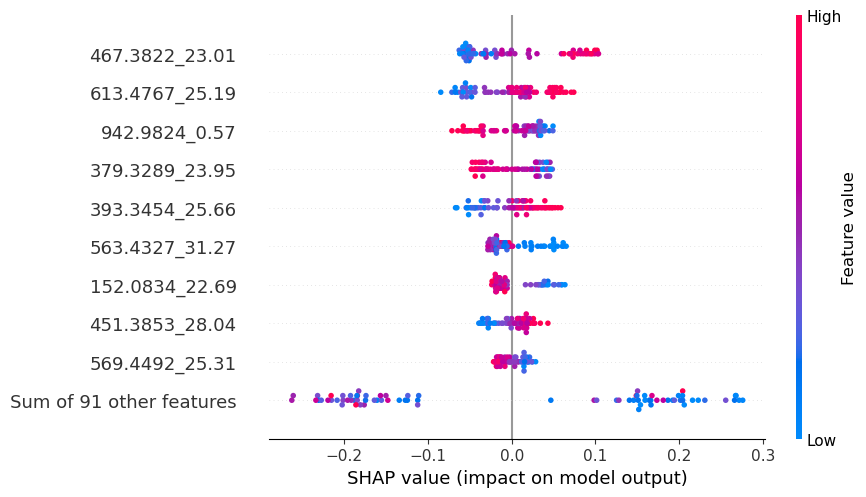

The plot is for label 1, corresponding to Factor1:CONTROL
starting with GradientBoostingClassifier estimator:
Shape of the SHAP values: (78, 100) for GradientBoostingClassifier estimator
The shap values do not exist for the label 1. The following is the beeswarm plot for all the labels.


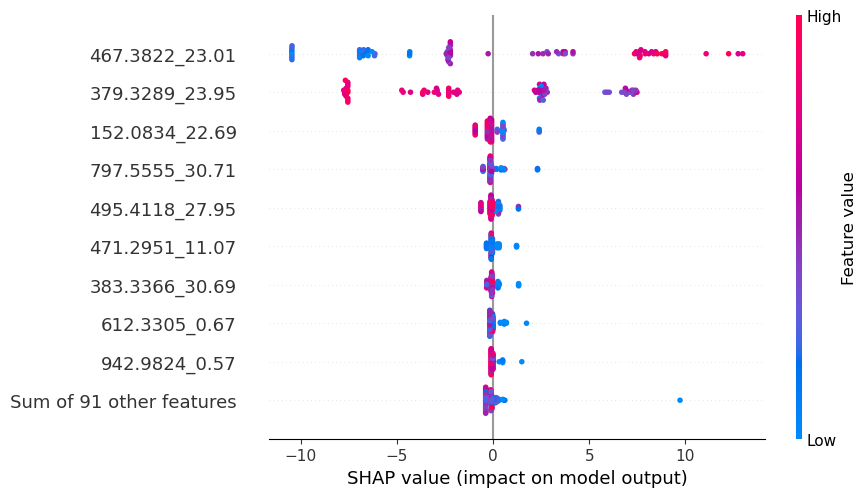

starting with LinearDiscriminantAnalysis estimator:
Shape of the SHAP values: (78, 100) for LinearDiscriminantAnalysis estimator
The shap values do not exist for the label 1. The following is the beeswarm plot for all the labels.


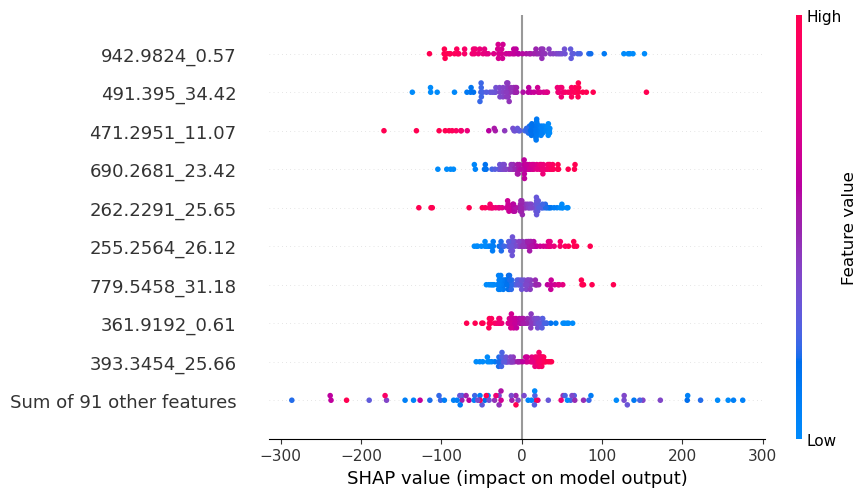

starting with LogisticRegression estimator:
Shape of the SHAP values: (78, 100) for LogisticRegression estimator
The shap values do not exist for the label 1. The following is the beeswarm plot for all the labels.


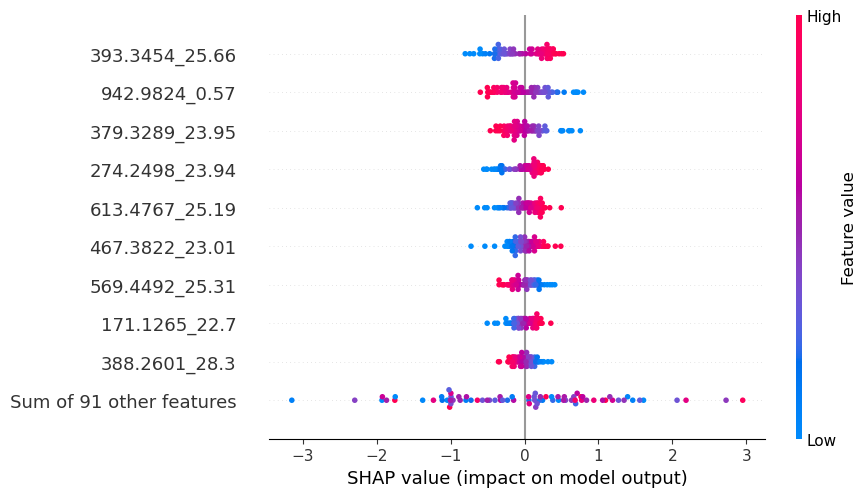

starting with XGBClassifier estimator:
Shape of the SHAP values: (78, 100) for XGBClassifier estimator
The shap values do not exist for the label 1. The following is the beeswarm plot for all the labels.


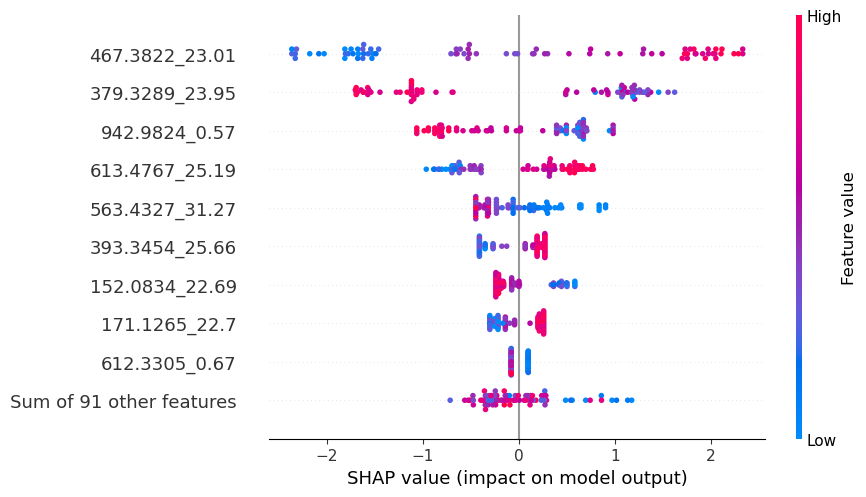

starting with GaussianNB estimator:
Switching to predict_proba due to compatibility issue with the model.
Shape of the SHAP values: (78, 100, 2) for GaussianNB estimator


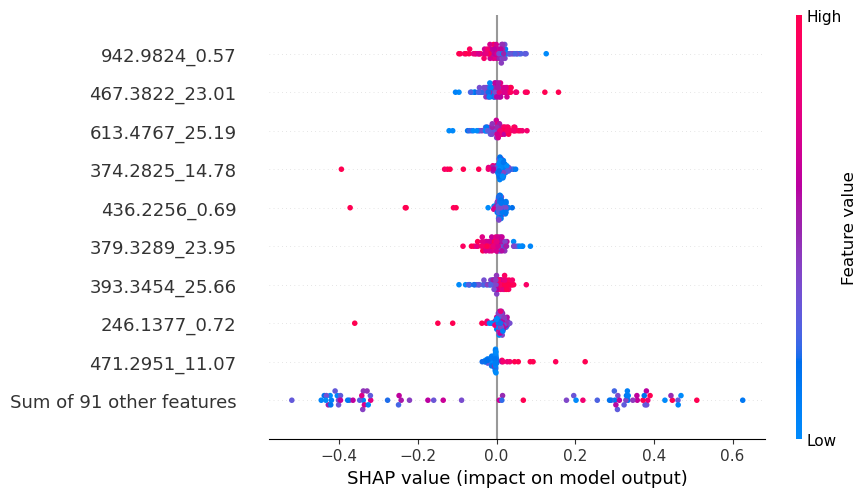

The plot is for label 1, corresponding to Factor1:CONTROL
starting with KNeighborsClassifier estimator:
Switching to predict_proba due to compatibility issue with the model.
Shape of the SHAP values: (78, 100, 2) for KNeighborsClassifier estimator


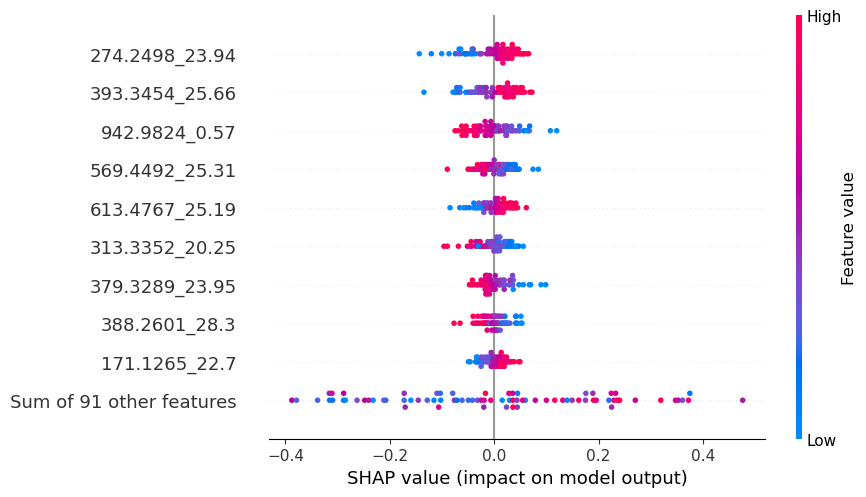

The plot is for label 1, corresponding to Factor1:CONTROL
starting with DecisionTreeClassifier estimator:
Shape of the SHAP values: (78, 100, 2) for DecisionTreeClassifier estimator


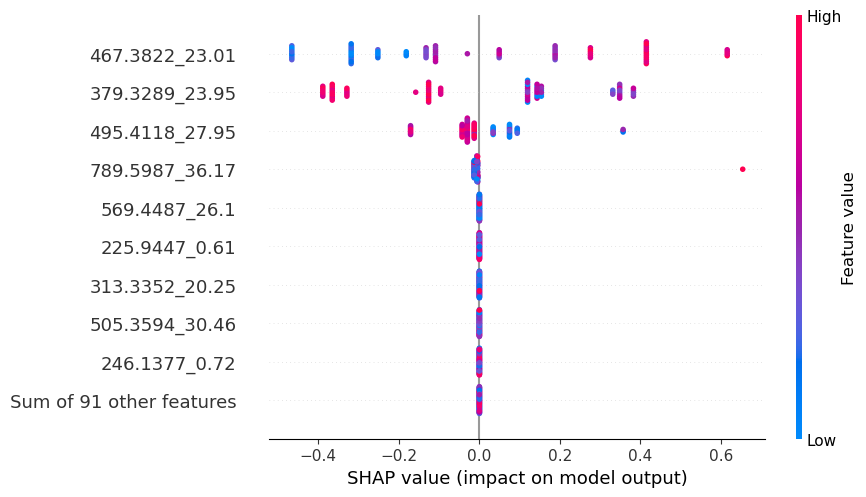

The plot is for label 1, corresponding to Factor1:CONTROL
starting with SVC estimator:
Switching to predict_proba due to compatibility issue with the model.


PermutationExplainer explainer: 79it [00:11,  1.38s/it]                        


Shape of the SHAP values: (78, 100, 2) for SVC estimator


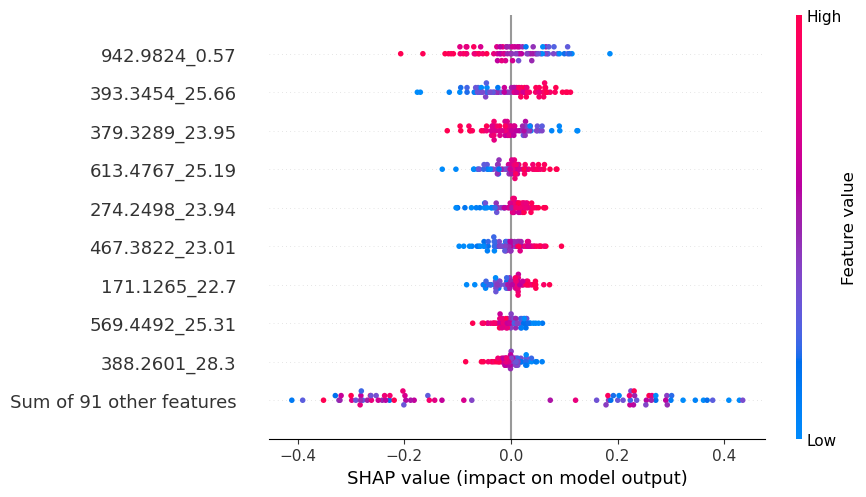

The plot is for label 1, corresponding to Factor1:CONTROL
starting with LGBMClassifier estimator:
[LightGBM] [Info] Number of positive: 39, number of negative: 39
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2696
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

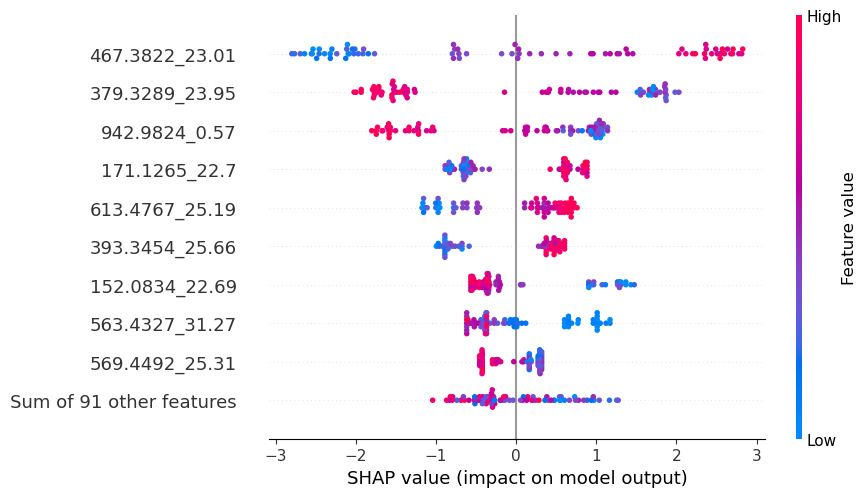

starting with GaussianProcessClassifier estimator:
Switching to predict_proba due to compatibility issue with the model.


PermutationExplainer explainer: 79it [00:15,  1.82it/s]                        


Shape of the SHAP values: (78, 100, 2) for GaussianProcessClassifier estimator


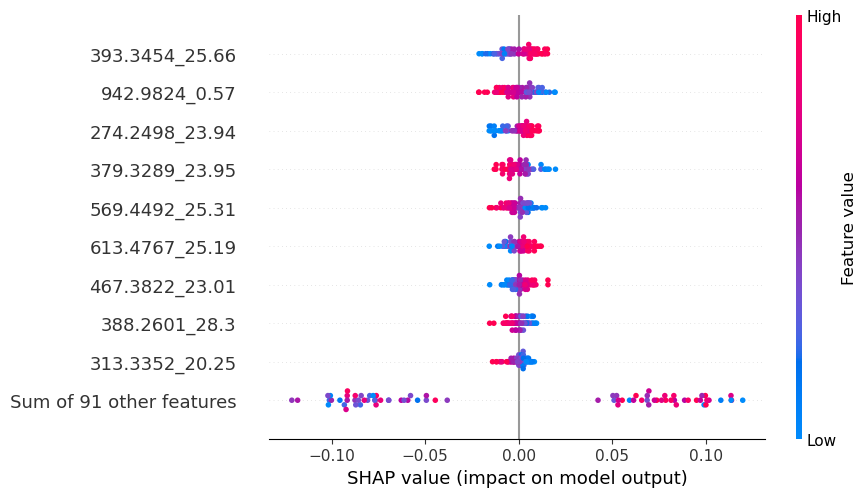

The plot is for label 1, corresponding to Factor1:CONTROL
starting with CatBoostClassifier estimator:
Learning rate set to 0.003466
0:	learn: 0.6909700	total: 1.24ms	remaining: 1.24s
1:	learn: 0.6881376	total: 2.43ms	remaining: 1.21s
2:	learn: 0.6855689	total: 3.63ms	remaining: 1.21s
3:	learn: 0.6825730	total: 4.75ms	remaining: 1.18s
4:	learn: 0.6794578	total: 5.82ms	remaining: 1.16s
5:	learn: 0.6759042	total: 6.85ms	remaining: 1.13s
6:	learn: 0.6736913	total: 7.94ms	remaining: 1.13s
7:	learn: 0.6715585	total: 9.03ms	remaining: 1.12s
8:	learn: 0.6696233	total: 10ms	remaining: 1.1s
9:	learn: 0.6669247	total: 11ms	remaining: 1.09s
10:	learn: 0.6640857	total: 12ms	remaining: 1.08s
11:	learn: 0.6618587	total: 12.9ms	remaining: 1.06s
12:	learn: 0.6586940	total: 13.9ms	remaining: 1.05s
13:	learn: 0.6565335	total: 14.8ms	remaining: 1.04s
14:	learn: 0.6528743	total: 15.7ms	remaining: 1.03s
15:	learn: 0.6493127	total: 16.7ms	remaining: 1.02s
16:	learn: 0.6466057	total: 17.5ms	remaining: 1.01s
1

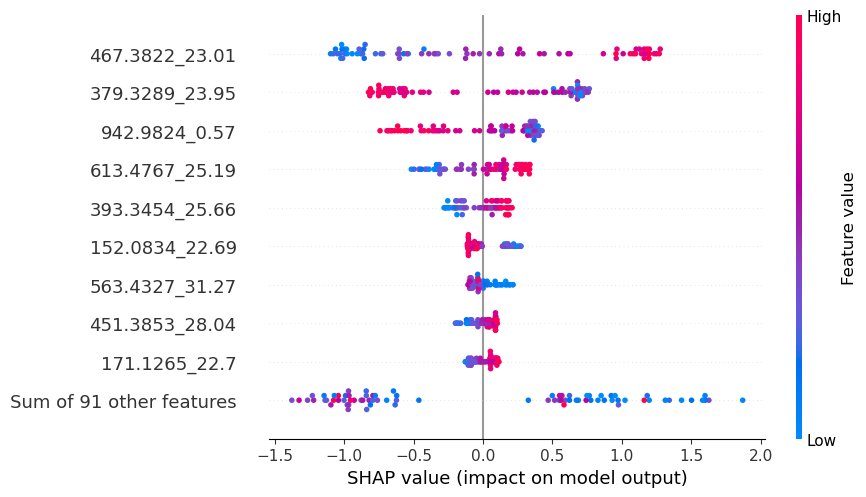

In [4]:
for estim_name, estimator in mlpipe.available_clfs.items():
    if estim_name is not 'SVC':
        print(f'starting with {estim_name} estimator:')
        mlpipe.best_estimator = estimator.fit(mlpipe.X, mlpipe.y)
        fesel = FeaturesExplanation(best_estimator=mlpipe.best_estimator, X=mlpipe.X, y=mlpipe.y, label_mapping=mlpipe.label_mapping)
        fesel.calculate_shap_values(explainer_type='general')
        print(f"Shape of the SHAP values: {fesel.shap_values.shape} for {estim_name} estimator")
    else :
        print(f'starting with {estim_name} estimator:')
        mlpipe.best_estimator = SVC(probability=True).fit(mlpipe.X, mlpipe.y)
        fesel = FeaturesExplanation(best_estimator=mlpipe.best_estimator, X=mlpipe.X, y=mlpipe.y, label_mapping=mlpipe.label_mapping)
        fesel.calculate_shap_values(explainer_type='general')
        print(f"Shape of the SHAP values: {fesel.shap_values.shape} for {estim_name} estimator")
    fesel.plot_shap_values(plot_type='beeswarm',label=1)
        

**Check tree option**

starting with RandomForestClassifier estimator:
Shape of the SHAP values: (78, 100, 2) for RandomForestClassifier estimator


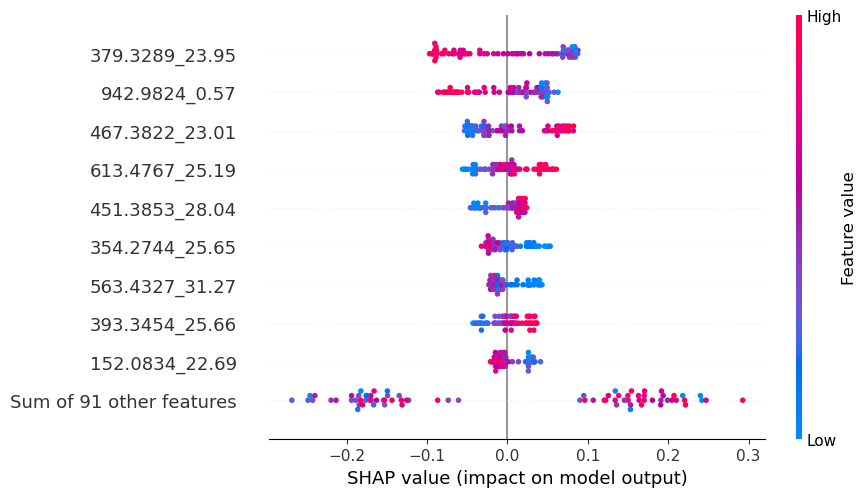

The plot is for label 1, corresponding to Factor1:CONTROL
starting with XGBClassifier estimator:
Shape of the SHAP values: (78, 100) for XGBClassifier estimator
The shap values do not exist for the label 1. The following is the beeswarm plot for all the labels.


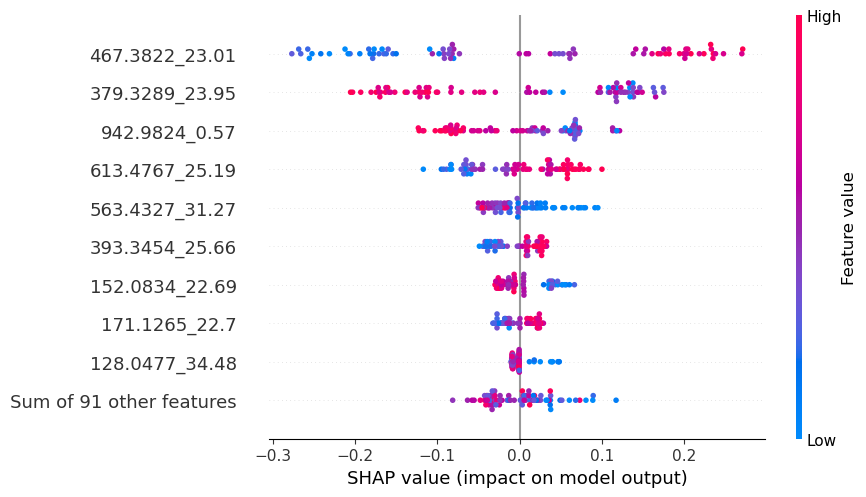

starting with DecisionTreeClassifier estimator:
Shape of the SHAP values: (78, 100, 2) for DecisionTreeClassifier estimator


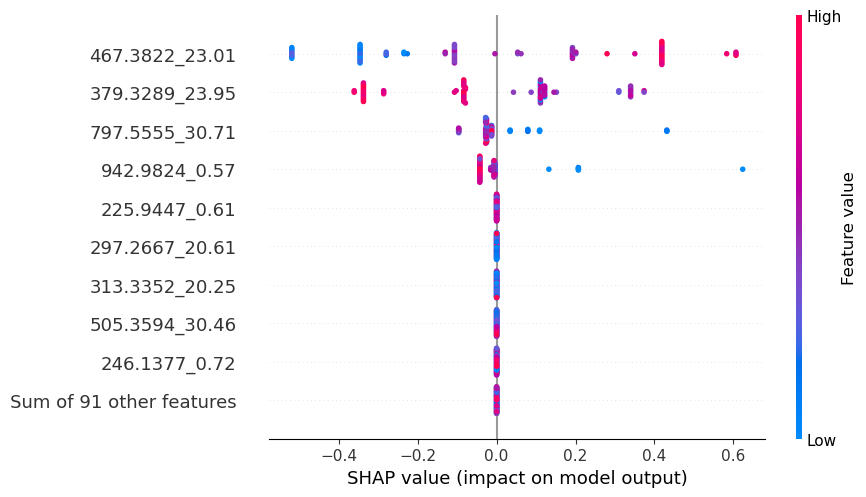

The plot is for label 1, corresponding to Factor1:CONTROL
starting with CatBoostClassifier estimator:
Learning rate set to 0.003466
0:	learn: 0.6909700	total: 1.11ms	remaining: 1.11s
1:	learn: 0.6881376	total: 2.03ms	remaining: 1.01s
2:	learn: 0.6855689	total: 3.04ms	remaining: 1.01s
3:	learn: 0.6825730	total: 3.9ms	remaining: 972ms
4:	learn: 0.6794578	total: 4.74ms	remaining: 944ms
5:	learn: 0.6759042	total: 5.6ms	remaining: 927ms
6:	learn: 0.6736913	total: 6.43ms	remaining: 912ms
7:	learn: 0.6715585	total: 7.26ms	remaining: 900ms
8:	learn: 0.6696233	total: 8.11ms	remaining: 893ms
9:	learn: 0.6669247	total: 8.98ms	remaining: 889ms
10:	learn: 0.6640857	total: 9.89ms	remaining: 890ms
11:	learn: 0.6618587	total: 11.3ms	remaining: 934ms
12:	learn: 0.6586940	total: 12.2ms	remaining: 928ms
13:	learn: 0.6565335	total: 13.1ms	remaining: 920ms
14:	learn: 0.6528743	total: 13.9ms	remaining: 915ms
15:	learn: 0.6493127	total: 15ms	remaining: 924ms
16:	learn: 0.6466057	total: 15.9ms	remaining: 917m

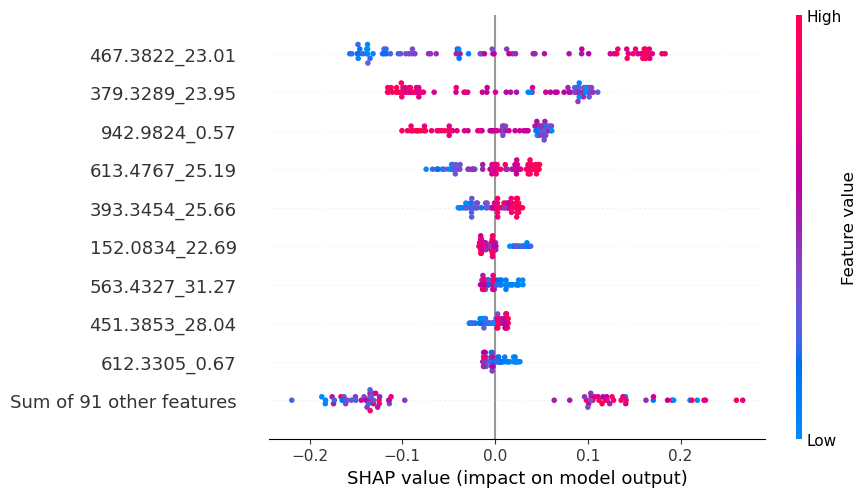

In [5]:
for estim_name, estimator in mlpipe.available_clfs.items():
    if estim_name not in ['DecisionTreeClassifier', 'RandomForestClassifier', 'XGBClassifier','CatBoostClassifier','LightGBMClassifier']:continue
    elif estim_name == 'XGBClassifier':
        print(f'starting with {estim_name} estimator:')
        mlpipe.best_estimator = XGBClassifier(booster='gbtree').fit(mlpipe.X, mlpipe.y)
        fesel = FeaturesExplanation(best_estimator=mlpipe.best_estimator, X=mlpipe.X, y=mlpipe.y, label_mapping=mlpipe.label_mapping)
        fesel.calculate_shap_values(explainer_type='tree')
        print(f"Shape of the SHAP values: {fesel.shap_values.shape} for {estim_name} estimator")
    else :
        print(f'starting with {estim_name} estimator:')
        mlpipe.best_estimator = estimator.fit(mlpipe.X, mlpipe.y)
        fesel = FeaturesExplanation(best_estimator=mlpipe.best_estimator, X=mlpipe.X, y=mlpipe.y, label_mapping=mlpipe.label_mapping)
        fesel.calculate_shap_values(explainer_type='tree')
        print(f"Shape of the SHAP values: {fesel.shap_values.shape} for {estim_name} estimator")
    fesel.plot_shap_values(plot_type='beeswarm',label=1)

**Check the linear option**

starting with LinearDiscriminantAnalysis estimator:
Shape of the SHAP values: (78, 100) for LinearDiscriminantAnalysis estimator
The shap values do not exist for the label 1. The following is the beeswarm plot for all the labels.


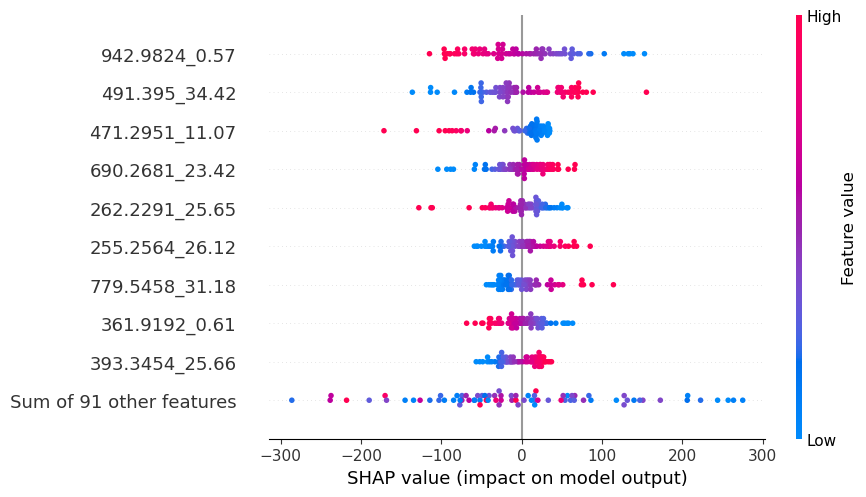

starting with LogisticRegression estimator:
Shape of the SHAP values: (78, 100) for LogisticRegression estimator
The shap values do not exist for the label 1. The following is the beeswarm plot for all the labels.


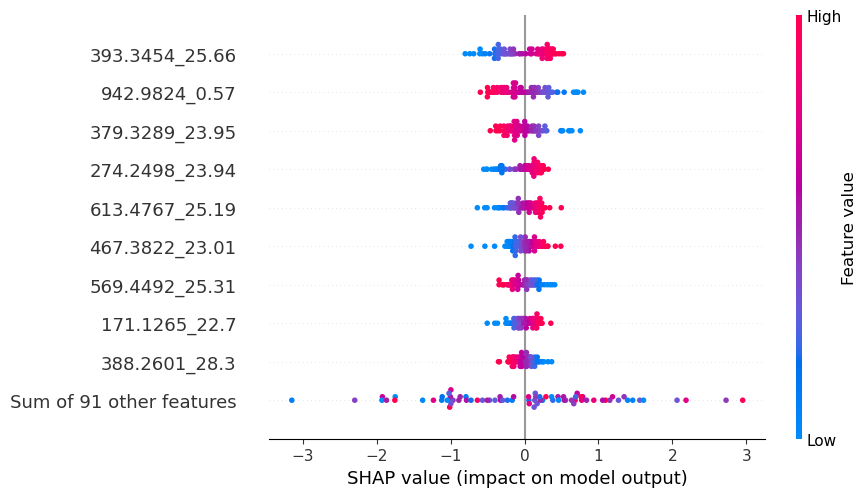

In [6]:
for estim_name, estimator in mlpipe.available_clfs.items():
    if estim_name not in ['LogisticRegression', 'LinearDiscriminantAnalysis']:continue
    else :
        print(f'starting with {estim_name} estimator:')
        mlpipe.best_estimator = estimator.fit(mlpipe.X, mlpipe.y)
        fesel = FeaturesExplanation(best_estimator=mlpipe.best_estimator, X=mlpipe.X, y=mlpipe.y, label_mapping=mlpipe.label_mapping)
        fesel.calculate_shap_values(explainer_type='linear')
        print(f"Shape of the SHAP values: {fesel.shap_values.shape} for {estim_name} estimator")
    fesel.plot_shap_values(plot_type='beeswarm',label=1)

#### after tests

In [35]:
mlpipe.bayesian_search(estimator_name='RandomForestClassifier',n_trials=20)
fesel = FeaturesExplanation(best_estimator=mlpipe.best_estimator, X=mlpipe.X, y=mlpipe.y, label_mapping=mlpipe.label_mapping)
fesel.calculate_shap_values(explainer_type='general')

  0%|          | 0/20 [00:00<?, ?it/s]

For the NoneType model: 
Best parameters: {'n_estimators': 67, 'criterion': 'gini', 'max_depth': 13, 'min_samples_leaf': 6, 'min_samples_split': 9, 'bootstrap': True}
Best matthews_corrcoef: 0.9763834207376394


In [49]:
fesel.plot_shap_values(plot_type='decision')

.values =
array([-0.05200294, -0.00131554, -0.00551843, -0.10278528,  0.03585746,
        0.0204886 , -0.00809637, -0.02298243, -0.00582557, -0.04569464,
        0.0057982 , -0.00010934, -0.00389475, -0.00812113,  0.00442841,
       -0.0061903 ,  0.00026045, -0.01045759, -0.00475671, -0.00050727,
       -0.01584258, -0.00912543, -0.01241204,  0.00520283, -0.0115073 ,
       -0.00559417, -0.00260215, -0.00174034,  0.00090879, -0.00135273,
        0.00222843, -0.00206306,  0.        , -0.00309411, -0.00251447,
        0.00091803, -0.00060139, -0.00553784, -0.00188845,  0.00188263,
       -0.00445613, -0.00328113,  0.00395003,  0.        , -0.00514026,
       -0.00556   , -0.00369843,  0.01939626,  0.00293895, -0.00168115])

.base_values =
0.4992420773016943

.data =
array([0.68267797, 0.05575916, 0.64021292, 0.46474467, 0.58386952,
       0.77488885, 0.47981039, 0.68662369, 0.6584425 , 0.6006144 ,
       0.45028874, 0.64569794, 0.77229056, 0.31818886, 0.17100221,
       0.22433053, 0.901

### Explainability

Normalization completed.
Number of significant features: 39 of 50 provided.


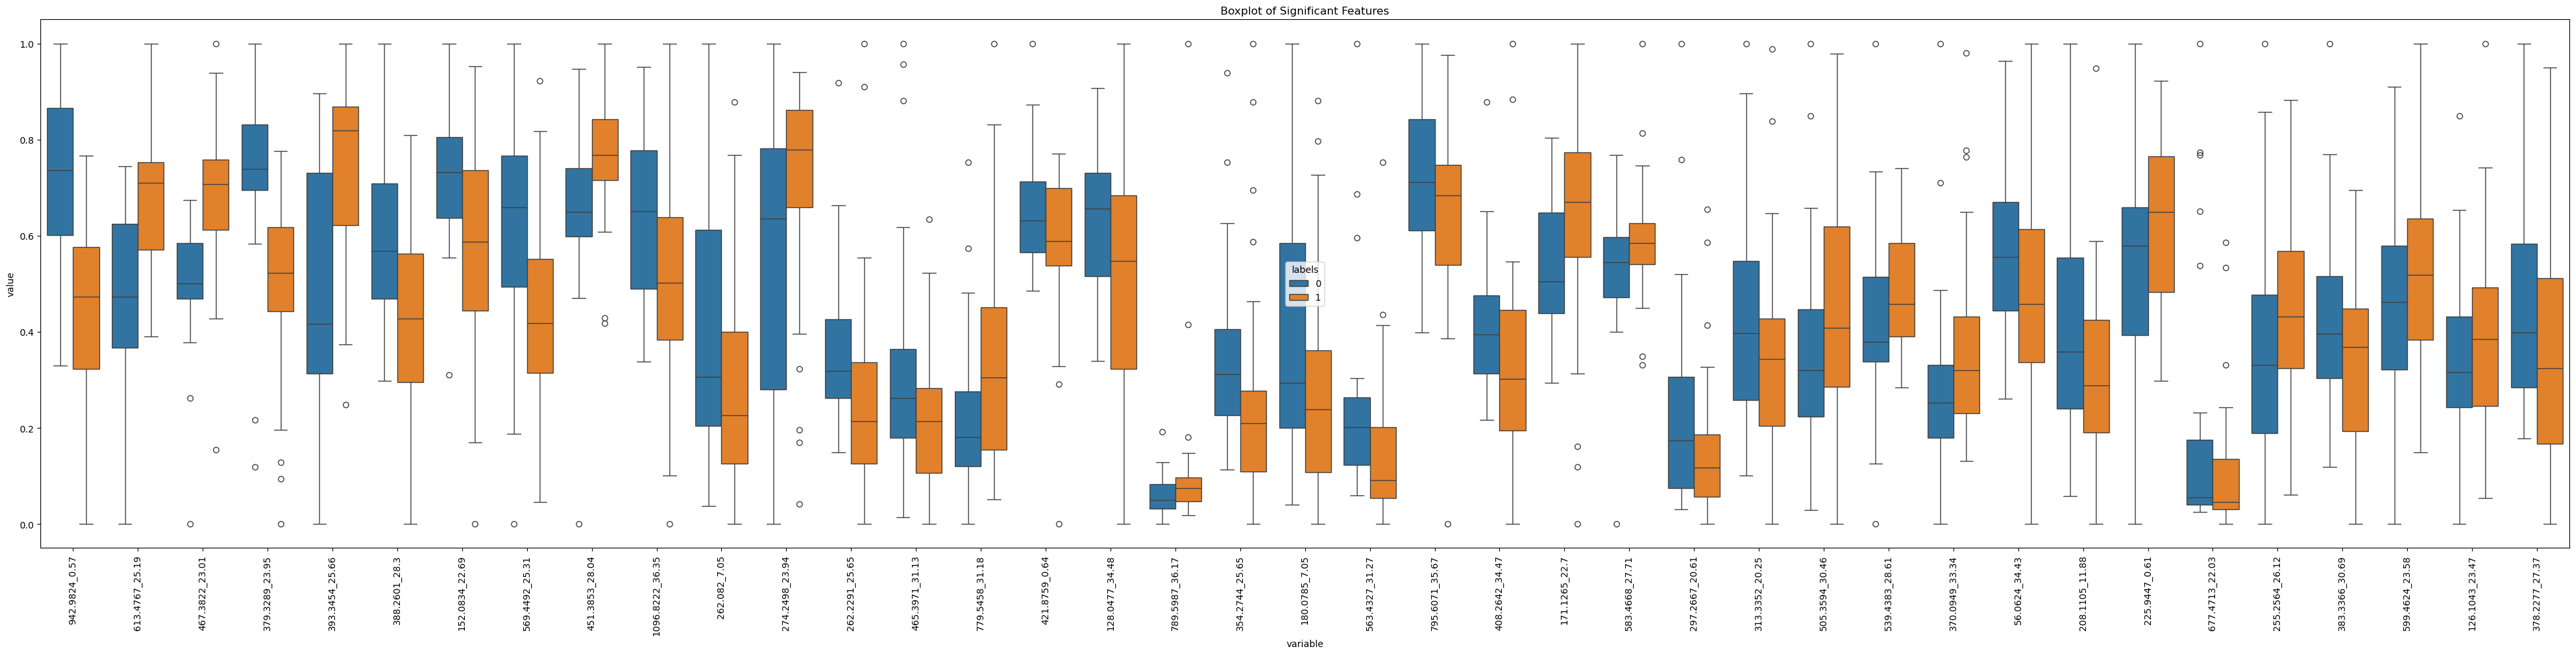

In [13]:
explore = ExploreExplain(mlpipe.X, mlpipe.y, normalization_method='minmax') ###μονο explore
# dataframe = explore.correlations(list_of_feature=None, limit=0.6, num_of_best_features=20, way_of_selection='mrmr')
# explore.pairplots_function(list_of_feature=None, way_of_selection='mrmr')
features_list = explore.statistical_difference( way_of_selection='mrmr',p_value=0.05, normalize=True)
# x = explore.pca_plot(variance_threshold=0.3,components_plot=3,missing_values_method='median')
# explore.umap_plot(n_components=[2,3], n_neighbors=[5,15], min_dist=[0.1,0.2],metric=['euclidean','manhattan'], random_state=0)
# explore.umap_plot()

In [14]:
features_list

['942.9824_0.57',
 '613.4767_25.19',
 '467.3822_23.01',
 '379.3289_23.95',
 '393.3454_25.66',
 '388.2601_28.3',
 '152.0834_22.69',
 '569.4492_25.31',
 '451.3853_28.04',
 '1096.8222_36.35',
 '262.082_7.05',
 '274.2498_23.94',
 '262.2291_25.65',
 '465.3971_31.13',
 '779.5458_31.18',
 '421.8759_0.64',
 '128.0477_34.48',
 '789.5987_36.17',
 '354.2744_25.65',
 '180.0785_7.05',
 '563.4327_31.27',
 '795.6071_35.67',
 '408.2642_34.47',
 '171.1265_22.7',
 '583.4668_27.71',
 '297.2667_20.61',
 '313.3352_20.25',
 '505.3594_30.46',
 '539.4383_28.61',
 '370.0949_33.34',
 '56.0624_34.43',
 '208.1105_11.88',
 '225.9447_0.61',
 '677.4713_22.03',
 '255.2564_26.12',
 '383.3366_30.69',
 '599.4624_23.58',
 '126.1043_23.47',
 '378.2277_27.37']

**int PCA**

In [4]:
# if __name__ == '__main__':
# explore = ExploreExplain(best_estimator=mlpipe.best_estimator, X=mlpipe.X, y=mlpipe.y, label_mapping=mlpipe.label_mapping, shap_values=fesel.shap_values.values, explainer=fesel.explainer,max_pca=5)
# explore.run_server()

NameError: name 'fesel' is not defined

In [46]:
# explore.create_interactive_pca_plot( n_components = 5, components=(0, 1),top_n_features=10)


FigureWidget({
    'data': [{'marker': {'color': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                                         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                                         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                                         1, 1, 1, 1, 1, 1]),
                         'colorscale': [[0.0, '#440154'], [0.1111111111111111,
                                        '#482878'], [0.2222222222222222,
                                        '#3e4989'], [0.3333333333333333,
                                        '#31688e'], [0.4444444444444444,
                                        '#26828e'], [0.5555555555555556,
                                        '#1f9e89'], [0.6666666666666666,
                                        '#35b779'], [0.7777777777777778,
                                        '#6ece58'], [0.8888888888888

In [52]:
# fesel.shap_values.values

array([[-0.38469295, -0.01836951,  0.04721795, ..., -0.00807175,
        -0.00506832, -0.00396822],
       [-0.47149721, -0.0074425 ,  0.0720573 , ..., -0.00696817,
        -0.00349263, -0.00208721],
       [-0.65896792, -0.00530387,  0.04691367, ..., -0.00334264,
        -0.00542308, -0.00492794],
       ...,
       [ 0.39534618,  0.00191326,  0.0202063 , ...,  0.00126525,
         0.0025304 ,  0.00437938],
       [ 0.40282136,  0.00231016,  0.14661677, ...,  0.0116305 ,
         0.00085436,  0.00664095],
       [ 0.09283673,  0.0057682 ,  0.23174899, ...,  0.00233226,
         0.00203122, -0.00266291]])

In [31]:
# def create_pca_dataframe(X, n_components):
#     """
#     Performs PCA on the given dataset X and returns a DataFrame with the principal components.

#     Parameters:
#     - X: array-like, shape (n_samples, n_features)
#         The input data to perform PCA on.
#     - n_components: int
#         The number of principal compon
# mean_shap_values = abs(fesel.shap_values.values).mean(axis=0)

# fig = make_subplots(rows=1, cols=2, subplot_titles=('PCA Plot', 'SHAP Values'),
#                     specs=[[{'type': 'scatter'}, {'type': 'bar'}]])

# scatter = go.Scatter(x=df_pca['PC1'], y=df_pca['PC2'], mode='markers', name='Data Points',
#                      marker=dict(color=fesel.y, colorscale='Viridis', showscale=True))

# bar = go.Bar(x=[f'Feature {i}' for i in range(len(mean_shap_values))], y=mean_shap_values)

# fig.add_trace(scatter, row=1, col=1)
# fig.add_trace(bar, row=1, col=2)

# fig.update_layout(showlegend=False, width=1000, height=500, clickmode='event+select')

# fig_widget = go.FigureWidget(fig)

# def update_shap_plot(trace, points, state):
#     if points.point_inds:
#         idx = points.point_inds[0]  
#         shap_values_point = fesel.shap_values.values[idx]  
#         with fig_widget.batch_update():
#             fig_widget.data[1].y = shap_values_point

# fig_widget.data[0].on_click(update_shap_plot)
# display(fig_widget)


In [22]:
# fesel.y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [10]:
# def create_interactive_pca_shap_plot(df_pca, X, components, image_size=(1000, 500),top_n_features=20):
#     """
#     Creates an interactive plot with PCA on one side and SHAP values on the other.

#     Parameters:
#     - df_pca: DataFrame containing PCA components.
#     - X: The original dataset used for PCA and SHAP value calculation.
#     - components: Tuple of indices for the PCA components to plot, e.g., (0, 1) for PC1 vs. PC2.
#     - image_size: Tuple for the image size, default to (1000, 500).

#     Returns:
#     - A Plotly FigureWidget with interactive capabilities in a Jupyter environment.
#     """
#     pc_x, pc_y = f'PC{components[0]+1}', f'PC{components[1]+1}'
    
#     mean_shap_values = abs(fesel.shap_values.values).mean(axis=0)
#     top_indices = mean_shap_values.argsort()[-top_n_features:][::-1]  # Indices of top features
#     top_mean_shap_values = mean_shap_values[top_indices]

#     fig = make_subplots(rows=1, cols=2, subplot_titles=('PCA Plot', 'SHAP Values'),
#                         specs=[[{'type': 'scatter'}, {'type': 'bar'}]],
#                         horizontal_spacing=0.1)
    
#     scatter = go.Scatter(x=df_pca[pc_x], y=df_pca[pc_y], mode='markers', name='Data Points',
#                          marker=dict(color=fesel.y, colorscale='Viridis', showscale=True))
#     fig.add_trace(scatter, row=1, col=1)

#     bar = go.Bar(x=[f'Feature {i}' for i in top_indices], y=top_mean_shap_values)
#     fig.add_trace(bar, row=1, col=2)

#     fig.update_layout(showlegend=False, width=image_size[0], height=image_size[1], clickmode='event+select')

#     # Convert to FigureWidget for interactivity in Jupyter
#     fig_widget = go.FigureWidget(fig)

#     # Define callback function for updates
#     def update_shap_plot(trace, points, selector):
#         if points.point_inds:
#             idx = points.point_inds[0]  
#             shap_values_point = fesel.shap_values.values[idx][top_indices]  
#             with fig_widget.batch_update():
#                 fig_widget.data[1].y = shap_values_point

#     fig_widget.data[0].on_click(update_shap_plot)

#     return fig_widget

In [12]:
# create_interactive_pca_shap_plot(df_pca, fesel.X, (0, 1), image_size=(1200, 800),top_n_features=100)

FigureWidget({
    'data': [{'marker': {'color': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                                         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                                         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                                         1, 1, 1, 1, 1, 1]),
                         'colorscale': [[0.0, '#440154'], [0.1111111111111111,
                                        '#482878'], [0.2222222222222222,
                                        '#3e4989'], [0.3333333333333333,
                                        '#31688e'], [0.4444444444444444,
                                        '#26828e'], [0.5555555555555556,
                                        '#1f9e89'], [0.6666666666666666,
                                        '#35b779'], [0.7777777777777778,
                                        '#6ece58'], [0.8888888888888